# MFT predictions of input distributions in fluctuation-driven multistability

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .01
X_MIN = -100
X_MAX = 100

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, D, mu_j, sgm_j, N=np.inf):
    """
    th \in [0, 1]^D
    u \in R^D
    v \in R_+^D
    D scalar
    mu_j \in R^{DxD}
    sgm_j \in R^{DxD}
    """
    mu_d = D*(mu_j @ th) + u
    sgm_d = np.sqrt(D*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_d_, sgm_d_) for mu_d_, sgm_d_ in zip(mu_d, sgm_d)])
    
    mnot_d = ~np.eye(len(th), dtype=bool) # masks for selecting all but one d
    
    th_next = np.nan*np.zeros(D)
    for d, (mu_d_, sgm_d_) in enumerate(zip(mu_d, sgm_d)):
        
        mask_d = mnot_d[d]
        th_next[d] = min(np.sum(norm(X, mu_d_, sgm_d_) * np.prod(phis[mask_d, :], axis=0))*DX, 1)
        
    if np.isinf(N):
        return th_next
    else:
        return np.random.multinomial(N, th_next)/N

In [3]:
def get_active(ths, t_1):
    ths_mn = ths[t_1:, :].mean(0)  # ppln time average
    matv = ths_mn > np.max(ths_mn/2)  # mask over active labels
    iatv = matv.nonzero()[0]  # idxs of active labels
    return iatv

## Fluctuation-driven simulation

Numerically estimate MFT steady state solution

In [5]:
t_max = 200

mu_0_fd = 0
mu_1_fd = 0
sgm_0_fd = 1
sgm_1_fd = .05

D = 16

mu_j = np.nan*np.zeros((D, D))
mu_j[np.eye(D, dtype=bool)] = mu_0_fd
mu_j[~np.eye(D, dtype=bool)] = mu_1_fd

sgm_j = np.nan*np.zeros((D, D))
sgm_j[np.eye(D, dtype=bool)] = sgm_0_fd
sgm_j[~np.eye(D, dtype=bool)] = sgm_1_fd

th_0 = 1 + .01*np.random.randn(D)
th_0 /= th_0.sum()

ths = np.nan*np.zeros((t_max, D))
ths[0, :] = th_0

for t_ in range(1, t_max):
    ths[t_, :] = alph(ths[t_-1, :], u=0, v=0, D=D, mu_j=mu_j, sgm_j=sgm_j, N=np.inf)

In [6]:
iatv = get_active(ths, t_1=150)
iqui = [d for d in range(D) if d not in iatv]

print('First active:', iatv[0])
print('First quiet:', iqui[0])

First active: 0
First quiet: 1


In [9]:
ths[-1, :]

array([0.10960119, 0.00194133, 0.00194133, 0.00194133, 0.10960119,
       0.10960119, 0.00194133, 0.00194133, 0.10960119, 0.00194133,
       0.00194133, 0.10960119, 0.10960119, 0.10960119, 0.10960119,
       0.10960119])

Compute input distributions analytically from firing rates

In [15]:
mu_x = D*mu_j@ths[-1, :]
sgm_x = np.sqrt(D*(sgm_j**2)@ths[-1, :])

rx = np.linspace(-5, 5, 101)
p_x_atv = stats.norm.pdf(rx, mu_x[iatv[0]], sgm_x[iatv[0]])
p_x_qui = stats.norm.pdf(rx, mu_x[iqui[0]], sgm_x[iqui[0]])

In [16]:
data = np.load('data/multistability/inputs.npy', allow_pickle=True)[0]

binc = data['binc']
cts_atv = data['cts_atv']
cts_qui = data['cts_qui']

Compare theory vs full simulations

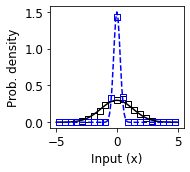

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(2.75, 2.5), tight_layout=True)
ax.plot(rx, p_x_atv, c='k')
ax.plot(rx, p_x_qui, c='b', ls='--')
ax.scatter(binc, cts_atv, marker='s', facecolors='none', edgecolors='k')
ax.scatter(binc, cts_qui, marker='s', facecolors='none', edgecolors='b')

set_plot(ax, x_label='Input (x)', y_label='Prob. density', font_size=12)

fig.savefig('figs/main/4_multi_inputs.svg')